In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
import acrona, pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [3]:
with open('../../Desktop/DLC_social_1/DLC_social_1_exp_conditions.pickle', 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [148]:
DLC_social_1 = acrona.get_coordinates(path='../../Desktop/DLC_social_1/',#Path where to find the required files
                              p=16,                              #Number of processes used for parallelization
                              smooth_alpha=0.1,                    #Alpha value for exponentially weighted smoothing
                              distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                                         'B_Right_flank','B_Tail_base'],
                              ego=False,
                              arena='circular',                  #Type of arena used in the experiments
                              arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                              video_format='.mp4',
                              table_format='.h5',
                              exp_conditions=Treatment_dict,
                              verbose=True)

In [149]:
DLC_social_1_coords = DLC_social_1.run()

Loading and smoothing trajectories...



Computing distance based coordinates...



Done!


In [150]:
print(DLC_social_1_coords)

Coordinates of 47 videos across 4 conditions


In [79]:
X_train, X_test = DLC_social_1_coords.get_coords().preprocess(window_size=50, window_step=10, test_proportion=0.05, scale=True, random_state=42)

In [80]:
X_train.shape

(66971, 50, 28)

In [17]:
DLC_social_1.ego

'B_Center'

In [165]:
import numpy as np
X, pca = DLC_social_1_coords.get_coords().tSNE(n_components=3, sample=1000)

<IPython.core.display.Javascript object>


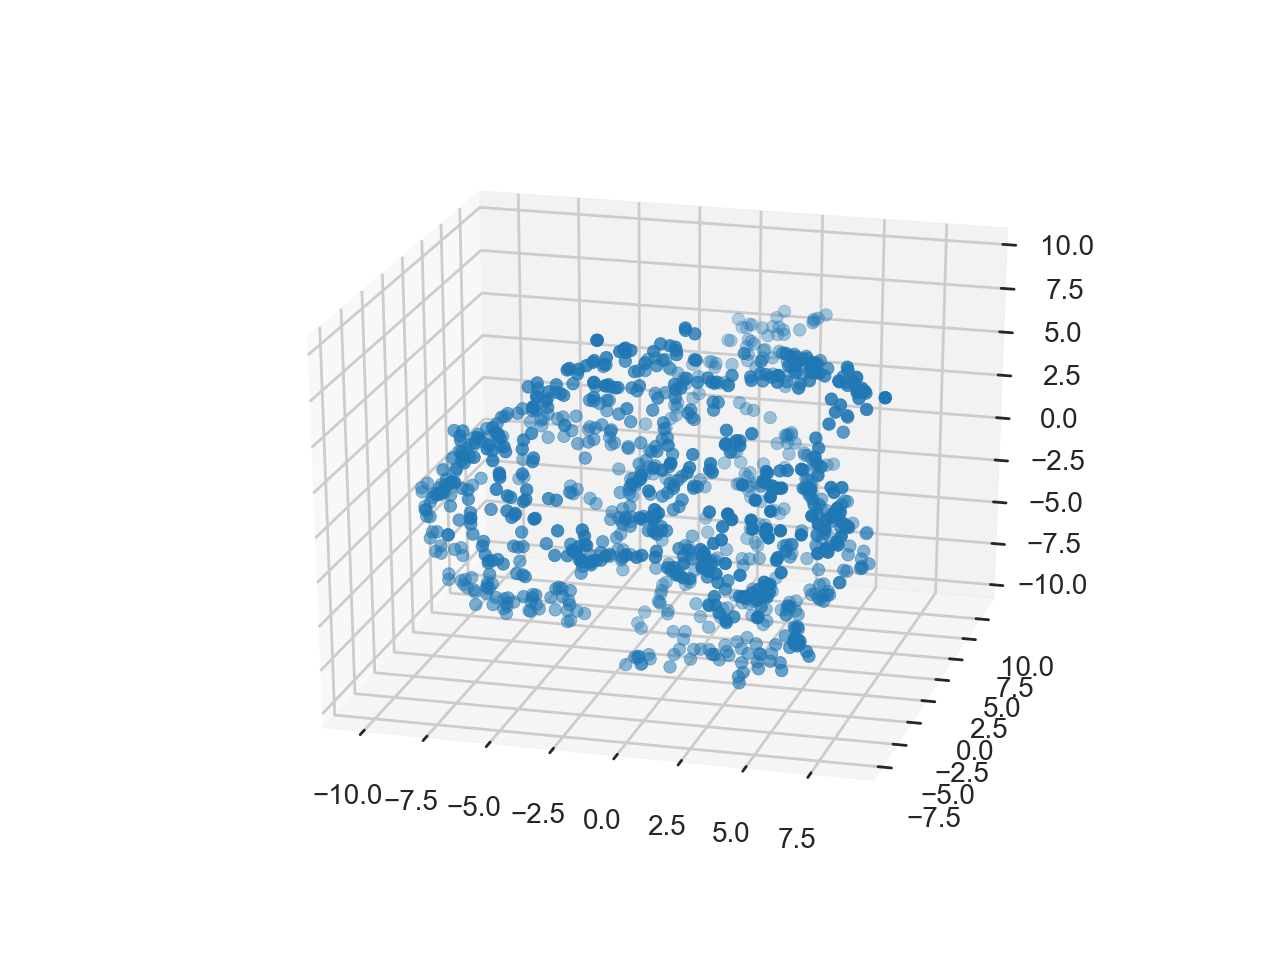

In [166]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2])

# DAE hyperparameter tuning

In [18]:
from AutoEncoder_HyperModels import *
from kerastuner.tuners import BayesianOptimization

INPUT_SHAPE = X_train.shape

hypermodel = SEQ_2_SEQ_AE(input_shape=INPUT_SHAPE)

tuner = BayesianOptimization(
        hypermodel,
        max_trials=100,
        executions_per_trial=3,
        objective='val_mae',
        seed=42,
        directory='BayesianOptx',
        project_name='acrona_LSTM_AE_tuning'
)

Using TensorFlow backend.


In [19]:
#tuner.search_space_summary()

In [167]:
N_EPOCH_SEARCH = 20
#tuner.search(X_train, X_train, epochs=N_EPOCH_SEARCH, validation_split=0.1, verbose=1, batch_size=1024)

In [ ]:
tuner.results_summary()

In [ ]:
best_model = tuner.get_best_models()
best_model

In [ ]:
best_model[0].save('LSTM_AE_BAYESIAN_OPT.h5', save_format='tf')

In [184]:
from keras.layers import Conv1D, Dropout, MaxPooling1D, Flatten, Dense

In [204]:
a = np.array([[1,2,3,4,5,6,7,8,9],[1,2,3,4,5,6,7,8,9]]).reshape(1,9,2)